In [1]:
import os
import numpy as np
import glob
import time
import warnings

from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, UpSampling2D, Activation, Add, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

from PIL import Image
from random import randint, shuffle, uniform

Using TensorFlow backend.


In [2]:
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=3, epsilon=1e-5, gamma_initializer = RandomNormal(1., 0.02))
def conv2d(x, *a, **k):
    return Conv2D(kernel_initializer = RandomNormal(0, 0.02), *a, **k)(x)

In [3]:
def resnet_block(x, filters=256, padding='same'):
    y = conv2d(x, filters, kernel_size=3, strides=1, padding=padding)
    y = LeakyReLU(alpha=0.2)(x)
    y = conv2d(x, filters, kernel_size=3, strides=1, padding=padding)
    
    return Add()([y, x])

In [4]:
def generator(image_size=256, channels=3, res_blocks=6):
    """Builds the generator that consists of an encoder, 
    a transformer and a decoder."""
    inputs = Input(shape=(image_size, image_size, channels))
    x = inputs
    
    # Encoder
    x = conv2d(x, 64, kernel_size=7, strides=1, padding='same')
    x = conv2d(x, 128, kernel_size=3, strides=2, padding='same')
    x = conv2d(x, 256, kernel_size=3, strides=2, padding='same')
    
    # Transformer
    for i in range(res_blocks):
        x = resnet_block(x)
        
    # Decoder
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = batchnorm()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    
    x = conv2d(x, 3, (7, 7), activation='tanh', strides=(1, 1) ,padding='same')    
    outputs = x
    
    return Model(inputs=inputs, outputs=outputs), inputs, outputs

In [5]:
def discriminator(image_size=256, channels=3, fl_filters=64, hidden_layers=3):
    inputs = Input(shape=(image_size, image_size, channels))
    x = inputs

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = conv2d(x, fl_filters, kernel_size=4, strides=2, padding='valid')
    x = LeakyReLU(alpha=0.2)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    for i in range(1, hidden_layers + 1):
        nf = 2 ** i * fl_filters
        x = conv2d(x, fl_filters, kernel_size=4, strides=2, padding='valid')
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
    x = conv2d(x, 1, kernel_size=4, activation='sigmoid', strides=(1, 1))
    outputs = x
    
    return Model(inputs=inputs, outputs=outputs)

In [6]:
def mse(output, target):
    diff = output - target
    dims = list(range(1,K.ndim(diff)))
    
    return K.expand_dims((K.mean(diff**2, dims)), 0)


def cycle_loss(reconstructed, real):
    diff = K.abs(reconstructed - real)
    dims = list(range(1,K.ndim(diff)))
    
    return K.expand_dims((K.mean(diff, dims)), 0)


def disc_loss(inputs):
    real, fake = inputs
    d_loss_real = mse(real, K.ones_like(real))
    d_loss_fake = mse(fake, K.zeros_like(fake))
    d_loss = (d_loss_real + d_loss_fake)/2
    
    return d_loss


def gen_loss(inputs, l=10):
    d_b_fake, a_rec, a_real, d_a_fake, b_rec, b_real = inputs
    g_a_loss = mse(d_b_fake, K.ones_like(d_b_fake))
    cycle_a_loss = cycle_loss(a_rec, a_real)
    g_b_loss = mse(d_a_fake, K.ones_like(d_a_fake))
    cycle_b_loss = cycle_loss(b_rec, b_real)
    
    g_loss = g_a_loss + g_b_loss + l*(cycle_a_loss + cycle_b_loss)
    
    return g_loss

In [7]:
d_a = discriminator()
d_b = discriminator()
g_a, a_real, a_fake = generator()
g_b, b_real, b_fake = generator()
# g_a.summary()
# g_b.summary()
# d_a.summary()
# d_b.summary()

In [8]:
d_b_fake = d_b(b_fake)
a_rec = g_b(b_fake)
d_a_fake = d_a(a_fake)
b_rec = g_a(a_fake)
lambda_layer_inputs = [d_b_fake, a_rec, a_real, d_a_fake, b_rec, b_real]

for l in g_a.layers: 
    l.trainable=True
for l in g_b.layers: 
    l.trainable=True
for l in d_a.layers: 
    l.trainable=False
for l in d_b.layers: 
    l.trainable=False

gen_train_function = Model([a_real, b_real], Lambda(gen_loss)(lambda_layer_inputs))
Adam(lr=2e-4, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0)
gen_train_function.compile('adam', 'mae')

In [9]:
d_a_real = d_a(a_real)
_a_fake = Input(shape=(256, 256, 3))
_d_a_fake = d_a(_a_fake)

for l in g_a.layers: 
    l.trainable=False
for l in g_b.layers: 
    l.trainable=False
for l in d_a.layers: 
    l.trainable=True
for l in d_b.layers: 
    l.trainable=False
    
d_a_train_function = Model([a_real, _a_fake], Lambda(disc_loss)([d_a_real, _d_a_fake]))
d_a_train_function.compile('adam', 'mae')

In [10]:
d_b_real = d_b(b_real)
_b_fake = Input(shape=(256, 256, 3))
_d_b_fake = d_b(_b_fake)

for l in g_a.layers: 
    l.trainable=False
for l in g_b.layers: 
    l.trainable=False
for l in d_a.layers: 
    l.trainable=False
for l in d_b.layers: 
    l.trainable=True
    
d_b_train_function = Model([b_real, _b_fake], Lambda(disc_loss)([d_b_real, _d_b_fake]))
d_b_train_function.compile('adam', 'mae')

In [16]:
def read_image(img, imagesize=256):
    img = Image.open(img).convert('RGB')
    img = img.resize((256, 256), Image.BICUBIC)
    img = np.array(img)
    img = img.astype(np.float32)
    img = (img - 127.5) / 127.5

    return img


# def try_read_img(data, index):
#     try:
#         img = read_image(data[index])
#         return img
#     except:
#         img = try_read_img(data, index + 1)
#         return img

trainA = glob.glob('data/horse2zebra/trainA/*')
trainB = glob.glob('data/horse2zebra/trainB/*')
print(len(trainA))
print(len(trainB))

1067
1334


In [17]:
def minibatch(data, batch_size=1):
    length = len(data)
    shuffle(data)
    epoch = i = 0  
    
    while True:
        size = batch_size
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = []
        for j in range(i,i+size):
            img = read_image(data[j])
            rtn.append(img)
        rtn = np.stack(rtn, axis=0)       
        i+=size
        tmpsize = yield epoch, np.float32(rtn)


def minibatchAB(dataA, dataB, batch_size=1):
    batchA=minibatch(dataA, batch_size)
    batchB=minibatch(dataB, batch_size)
    tmpsize = None    
    while True:
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

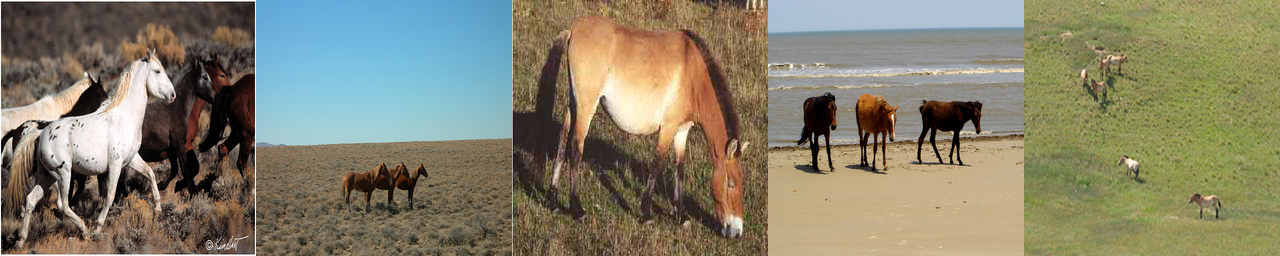

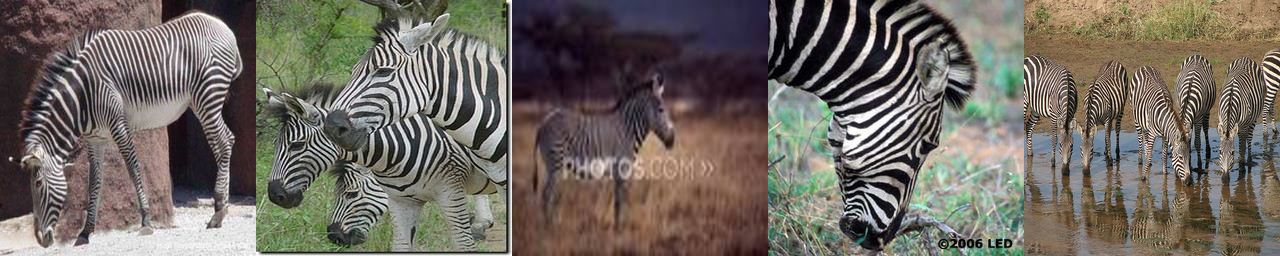

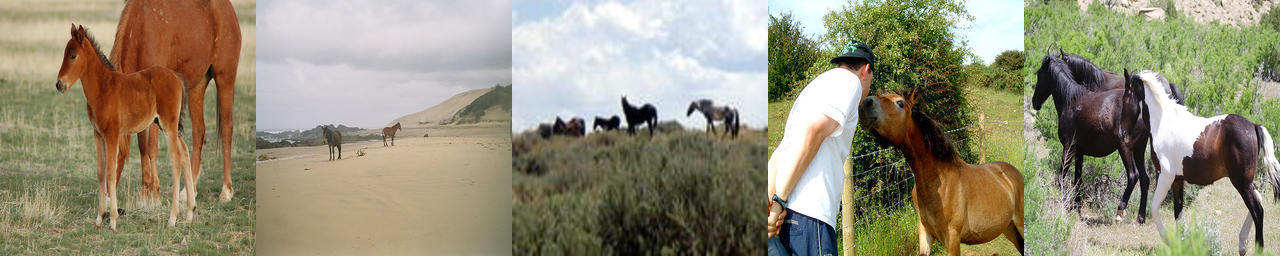

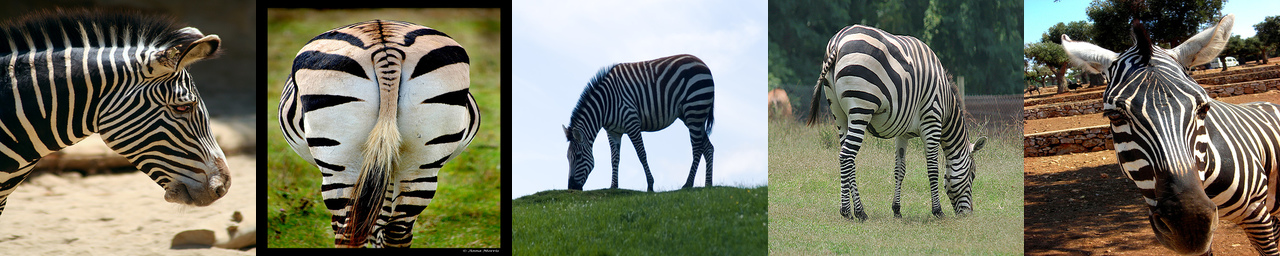

In [22]:
from IPython.display import display
def display_image(X, rows=1, image_size=256):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
#     pil_X.save(dpath+'results/'+ t, 'JPEG')
    display(pil_X)

train_batch = minibatchAB(trainA, trainB, 5)

_, A, B = next(train_batch)
display_image(A)
display_image(B)
_, A, B = next(train_batch)
display_image(A)
display_image(B)
del train_batch, A, B

In [23]:
def get_output(g_a, g_b, X):
    real_input = X
    fake_output = g_a.predict(real_input)
    rec_input = g_b.predict(fake_output)
    outputs = [fake_output, rec_input]
    
    return outputs

In [24]:
def get_combined_output(g_a, g_b, X):
    r = [get_output(g_a, g_b, X[i:i+1]) for i in range(X.shape[0])]
    r = np.array(r)
    return r.swapaxes(0,1)[:,:,0]

In [25]:
def show_generator_image(A, B, g_a, g_b):
    assert A.shape==B.shape
      
    rA = get_combined_output(g_a, g_b, A)
    rB = get_combined_output(g_b, g_a, B)
    
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])    
    display_image(arr, 3)

In [26]:
def get_generator_function(g):
    real_input = g.inputs[0]
    fake_output = g.outputs[0]
    function = K.function([real_input, K.learning_phase()], [fake_output])
    return function

g_a_function = get_generator_function(g_a)
g_b_function = get_generator_function(g_b)

In [27]:
class ImagePool():
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        
        return_images = []
        for image in images:
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = uniform(0, 1)
                if p > 0.5:
                    random_id = randint(0, self.pool_size-1)
                    tmp = self.images[random_id]
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = np.stack(return_images, axis=0)
        
        return return_images

In [29]:
import time
from IPython.display import clear_output
batch_size = 1
start_time = time.time()
epochs = 200
iteration_count = 0
epoch_count = 0
display_freq = 1000 // batch_size 
save_freq = 20000 // batch_size

train_batch = minibatchAB(trainA, trainB, batch_size)
    
fake_A_pool = ImagePool()
fake_B_pool = ImagePool()

while epoch_count < epochs:
    target_label = np.zeros((batch_size, 1))
    epoch_count, A, B = next(train_batch)

    tmp_fake_B = g_a_function([A])[0]
    tmp_fake_A = g_b_function([B])[0]

    _fake_B = fake_B_pool.query(tmp_fake_B)
    _fake_A = fake_A_pool.query(tmp_fake_A)

    gen_train_function.train_on_batch([A, B], target_label)

    d_b_train_function.train_on_batch([B, _fake_B], target_label)
    d_a_train_function.train_on_batch([A, _fake_A], target_label)
    
    iteration_count += 1
    
    if iteration_count%display_freq == 0:
        clear_output()
        timecost =  (time.time() - start_time)/60
        print('epoch_count: {}  iter_count: {}  timecost: {}mins'.format(epoch_count, iteration_count, timecost))
        show_generator_image(A, B, g_a, g_b)



/Users/mstazherova/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: 